In [1]:
%load_ext autoreload
%autoreload 2

import logging

import helpers.hdbg as hdbg
import helpers.hprint as hprint

hprint.config_notebook()

# hdbg.init_logger(verbosity=logging.DEBUG)
hdbg.init_logger(verbosity=logging.INFO)
# hdbg.test_logger()
_LOG = logging.getLogger(__name__)

INFO: > cmd='/venv/lib/python3.8/site-packages/ipykernel_launcher.py -f /root/.local/share/jupyter/runtime/kernel-b3588eaa-207d-4cc0-a3ce-351e8ada76f1.json'


# Generate random data

In [2]:
import numpy as np

import oms.obsolete.pnl_simulator as oobpnsim

df = oobpnsim.get_random_market_data(21)

display(df.head(3))
display(df.tail(3))

,price,ask,bid
2021-09-12 09:30:00,100.496714,100.722490,100.381066
2021-09-12 09:31:00,100.358450,100.425978,100.057346
2021-09-12 09:32:00,101.006138,102.430887,99.527616


,price,ask,bid
2021-09-12 09:48:00,97.986332,98.183194,97.507158
2021-09-12 09:49:00,96.574029,97.312495,96.388370
2021-09-12 09:50:00,98.039678,98.211046,96.933343


## Lag-based PnL vs Level1 simulation

In [3]:
mode = "instantaneous"
df_5mins = oobpnsim.resample_data(df, mode)
display(df_5mins)

,price,ask,bid,ret_0,preds
2021-09-12 09:30:00,100.496714,100.722490,100.381066,NaN,-1.0
2021-09-12 09:35:00,102.060878,103.211871,101.003756,0.015564,1.0
2021-09-12 09:40:00,104.017193,105.869472,103.340271,0.019168,1.0
2021-09-12 09:45:00,99.592940,99.801804,99.283728,-0.042534,0.0
2021-09-12 09:50:00,98.039678,98.211046,96.933343,-0.015596,0.0


<AxesSubplot:>

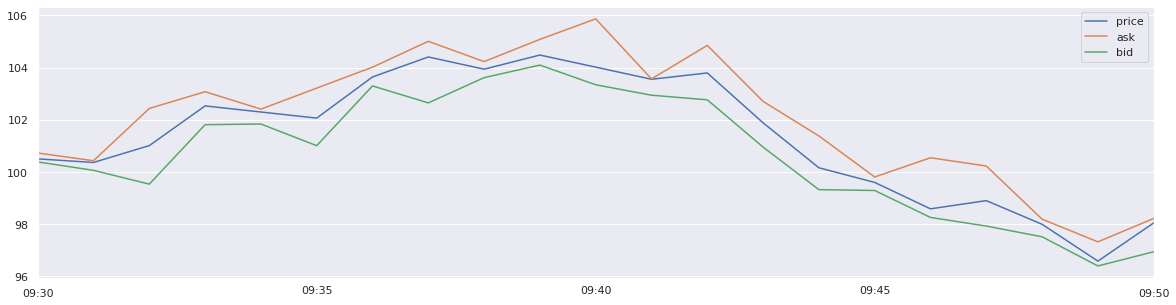

In [4]:
df.plot()

In [5]:
df, df_5mins = oobpnsim.get_example_market_data1()

display(df_5mins)

,price,preds,ret_0
2021-09-12 09:30:00,100,1.0,NaN
2021-09-12 09:35:00,90,-1.0,-0.100000
2021-09-12 09:40:00,80,1.0,-0.111111
2021-09-12 09:45:00,90,0.0,0.125000
2021-09-12 09:50:00,70,0.0,-0.222222


In [6]:
# Compute pnl using simulation.
w0 = 100.0
final_w, tot_ret, df_5mins = oobpnsim.compute_pnl_level1(w0, df, df_5mins)

print(final_w, tot_ret)

60.49382716049382 -0.39506172839506176


In [7]:
# Compute pnl using lags.
# df_5mins["pnl"] = df_5mins["preds"] * df_5mins["ret_0"].shift(-2)
# tot_ret2 = (1 + df_5mins["pnl"]).prod() - 1
# display(df_5mins[:-1])

tot_ret2, df_5mins = oobpnsim.compute_lag_pnl(df_5mins)

# Check that the results are the same.
print("tot_ret=", tot_ret)
print("tot_ret2=", tot_ret2)
np.testing.assert_almost_equal(tot_ret, tot_ret2)

tot_ret= -0.39506172839506176
tot_ret2= -0.3950617283950618


## Lag-based PnL vs Level1 vs Level2 simulation

In [8]:
mode = "instantaneous"
df, df_5mins = oobpnsim.get_example_market_data1()

# Level 1 sim.
initial_wealth = 1000
final_w, tot_ret, df_5mins = oobpnsim.compute_pnl_level1(
    initial_wealth, df, df_5mins
)
# Lag-based sim.
tot_ret2, df_5mins = oobpnsim.compute_lag_pnl(df_5mins)

# Level 2 sim.
config = {
    "price_column": "price",
    "future_snoop_allocation": True,
    "order_type": "price.end",
}

df_5mins = oobpnsim.compute_pnl_level2(df, df_5mins, initial_wealth, config)

df_5mins

,price,preds,ret_0,num_shares,diff,wealth,pnl.sim1,pnl.lag,target_n_shares,cash,holdings,diff_n_shares,filled_n_shares,cash+1,holdings+1,pnl.sim2
2021-09-12 09:30:00,100,1.0,NaN,11.111111,-111.111111,1000.000000,-0.111111,-0.111111,11.111111,1.000000e+03,0.000000,11.111111,11.111111,0.000000e+00,11.111111,NaN
2021-09-12 09:35:00,90,-1.0,-0.100000,11.111111,-111.111111,1000.000000,-0.125000,-0.125000,-11.111111,0.000000e+00,11.111111,-22.222222,-22.222222,1.777778e+03,-11.111111,0.000000
2021-09-12 09:40:00,80,1.0,-0.111111,8.641975,-172.839506,888.888889,-0.222222,-0.222222,8.641975,1.777778e+03,-11.111111,19.753086,19.753086,-2.273737e-13,8.641975,-0.111111
2021-09-12 09:45:00,90,0.0,0.125000,NaN,NaN,777.777778,0.000000,NaN,0.000000,-2.273737e-13,8.641975,-8.641975,-8.641975,6.049383e+02,0.000000,-0.125000
2021-09-12 09:50:00,70,0.0,-0.222222,NaN,NaN,604.938272,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.222222
